In [1]:
import pandas as pd 
import numpy as np
import jieba
import synonyms
import math
import scipy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from gensim.corpora import Dictionary
from gensim import corpora
from gensim.models import LdaModel, Word2Vec
from transformers import BertTokenizer
from transformers import BertModel
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import logging
from transformers import BertModel
from torch.autograd import Variable
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
logging.set_verbosity_error()
from collections import Counter
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors
from transformers.data.processors.utils import InputExample, DataProcessor

[jieba] default dict file path ..\data\vocab.txt


Building prefix dict from D:\anaconda\envs\pytorch\lib\site-packages\synonyms\data\vocab.txt ...
Loading model from cache C:\Users\HTHDS\AppData\Local\Temp\jieba.u9fe795a5016171614f69e09ca5cafd4f.cache


>> Synonyms load wordseg dict [D:\anaconda\envs\pytorch\lib\site-packages\synonyms\data\vocab.txt] ... 


Loading model cost 3.101 seconds.
Prefix dict has been built successfully.


>> Synonyms on loading stopwords [D:\anaconda\envs\pytorch\lib\site-packages\synonyms\data\stopwords.txt] ...
[Synonyms] on loading vectors [D:\anaconda\envs\pytorch\lib\site-packages\synonyms\data\words.vector.gz] ...


D:\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    get_linear_schedule_with_warmup,
    BertConfig,
    BertModel,
    BertPreTrainedModel,
    BertTokenizer,)

In [3]:
import logging
logger=logging.getLogger(__name__)

In [4]:
plt.rcParams['font.sans-serif'] = ['SimHei']   # 解决汉字显示为□指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决保存图像时 负号'-' 显示为□和报错的问题

## 读取数据

In [5]:
df1 = pd.concat([pd.read_excel('data/2018-2019茂名（含自媒体）.xlsx', sheet_name='游记攻略'), pd.read_excel('data/2020-2021茂名（含自媒体）.xlsx', sheet_name='游记攻略')], ignore_index=True)
df2 = pd.concat([pd.read_excel('data/2018-2019茂名（含自媒体）.xlsx', sheet_name='酒店评论'), pd.read_excel('data/2020-2021茂名（含自媒体）.xlsx', sheet_name='酒店评论')], ignore_index=True)
df3 = pd.concat([pd.read_excel('data/2018-2019茂名（含自媒体）.xlsx', sheet_name='景区评论'), pd.read_excel('data/2020-2021茂名（含自媒体）.xlsx', sheet_name='景区评论')], ignore_index=True)
df4 = pd.concat([pd.read_excel('data/2018-2019茂名（含自媒体）.xlsx', sheet_name='餐饮评论'), pd.read_excel('data/2020-2021茂名（含自媒体）.xlsx', sheet_name='餐饮评论')], ignore_index=True)
df5 = pd.concat([pd.read_excel('data/2018-2019茂名（含自媒体）.xlsx', sheet_name='微信公众号新闻'), pd.read_excel('data/2020-2021茂名（含自媒体）.xlsx', sheet_name='微信公众号新闻')], ignore_index=True)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   游记ID    294 non-null    int64 
 1   城市      294 non-null    object
 2   游记标题    294 non-null    object
 3   发布时间    294 non-null    object
 4   出发时间    262 non-null    object
 5   出行天数    257 non-null    object
 6   人物      262 non-null    object
 7   人均费用    224 non-null    object
 8   正文      294 non-null    object
dtypes: int64(1), object(8)
memory usage: 20.8+ KB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   酒店评论ID  1093 non-null   int64 
 1   城市      1093 non-null   object
 2   酒店名称    1093 non-null   object
 3   评论日期    1093 non-null   object
 4   评论内容    1093 non-null   object
 5   入住日期    1093 non-null   object
 6   入住房型    1093 non-null   object
dtypes: int64(1), object(6)
memory usage: 59.9+ KB


In [8]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   景区评论ID  1203 non-null   int64 
 1   城市      1203 non-null   object
 2   景区名称    1203 non-null   object
 3   评论日期    1203 non-null   object
 4   评论内容    1203 non-null   object
dtypes: int64(1), object(4)
memory usage: 47.1+ KB


In [9]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6984 entries, 0 to 6983
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   餐饮评论ID  6984 non-null   int64 
 1   城市      6984 non-null   object
 2   餐饮名称    6984 non-null   object
 3   评论日期    6984 non-null   object
 4   评论内容    6984 non-null   object
 5   标题      6984 non-null   object
dtypes: int64(1), object(5)
memory usage: 327.5+ KB


In [10]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6286 entries, 0 to 6285
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   文章ID    6286 non-null   int64 
 1   公众号标题   6285 non-null   object
 2   发布时间    6286 non-null   object
 3   正文      6286 non-null   object
dtypes: int64(1), object(3)
memory usage: 196.6+ KB


## 数据预处理

### 缺失值填充

In [11]:
df1[['人物','人均费用']]

,人物,人均费用
0,NaN,NaN
1,NaN,NaN
2,一个人,400RMB
3,和朋友,50RMB
4,一个人,800RMB
...,...,...
289,NaN,NaN
290,NaN,NaN
291,家庭出游,250RMB
292,家庭出游,500RMB


In [12]:
df1['人均费用_'] = df1['人均费用'].apply(lambda s:str(s).split('RMB')[0])

In [13]:
df1['人均费用_'] = df1['人均费用_'].astype(float)

In [14]:
df1['人均费用_'].fillna(df1['人均费用_'].mean(), inplace=True)

In [15]:
df1.head()

,游记ID,城市,游记标题,发布时间,出发时间,出行天数,人物,人均费用,正文,人均费用_
0,1001,茂名,漫游中国之三、广东(下)……茂名、惠州、河源、和平、韶关,2018-05-02 07:46,NaN,NaN,NaN,NaN,1、茂名放鸡岛\n放鸡岛 （原名湾舟岛，又名汾洲岛）是位于 广东 省 茂名 市 电白 区博贺...,1491.589286
1,1002,茂名,粤西美食| 茂名，心中的美食城（不定时更新）,2018-10-15 22:21,NaN,NaN,NaN,NaN,【茂名在哪】\n我的大 茂名 位于 广东 西部，简称粤西，很多人都不知道 茂名 是哪，所以我...,1491.589286
2,1003,茂名,【茂名】三日游记,2018-11-15 11:38,2018-08-25,3 天,一个人,400RMB,行程总览\n【地点】\n茂名\n\n【时间】\n3天（实际游玩时间约2天半）\n\n【交通】...,400.000000
3,1004,茂名,几分钟和你吃遍茂名美食-粤西茂名家乡发展有你我,2018-11-30 18:12,2018-11-30,1 天,和朋友,50RMB,前言\n几分钟真的吃不遍 茂名 ，题目只是一个噱头 🔥🔥这是我第一次写家乡的游记 很多店我觉...,50.000000
4,1005,茂名,寻找茂名的历史——周末游高州、化州,2018-12-06 08:09,2018-11-24,2 天,一个人,800RMB,茂名 原本相对于 广州 而言，交通稍差，不适合周末二日游。随着江湛铁路的开通，交通已经不成问...,800.000000


### 去除微信文章换行符

In [16]:
df5['正文'] = df5['正文'].apply(lambda cont:str(cont).replace('\n', ''))

In [17]:
df5['正文'].head()

0    2017的旅程已经结束2018的未来拉开了帷幕新的一年里，请对自己好一点一辈子很长，漫漫人生...
1    距离春节还有一个多月的时间，在线旅游网站的春节机票销售火爆，部分航线甚至一票难求。在这里分享...
2    960万平方公里的祖国大地，四季都有独特美景冬天的旅行也别有一番风味但是冬季的严寒气候令很多...
3    长按二维码，关注我们中心联系人：林小姐13709649096刘小姐13500078199罗小...
4                                                     
Name: 正文, dtype: object

### 文旅主题词扩展

#### 种子主题词

In [18]:
# 旅游主题词
with open('data/themewords.txt', encoding='utf-8') as fp:
    words = fp.readlines()
    theme = [s.replace('\n', '').strip() for s in words]

#### 扩展文旅主题词

In [19]:
def extend_theme(theme):
    extend = []
    for s in theme:
        similar = synonyms.nearby(s, size=10)
        for w, v in zip(similar[0], similar[1]):
            if v > 0.7:
                extend.append(w)
    themes = set(theme+extend)
    with open('data/extendtheme.txt', 'w+', encoding='utf-8', newline='') as fp:
        for w in themes:
            fp.write(w)
            fp.write('\n')

In [20]:
extend_theme(theme)

## 公众号文章内容分词预处理

In [21]:
# 添加自定义词典
jieba.load_userdict('data/extendtheme.txt')

In [22]:
# 停用词
with open('data/stopword.txt', encoding='utf-8') as fp:
    words = fp.readlines()
    stopwords = [s.replace('\n', '').strip() for s in words] + ['\n', ' ', '茂名', '茂名市', '广东', '广东省', '中国',
                '国家', '全国',]

In [23]:
stopwords

['',
 '，',
 '】',
 '【',
 ',',
 '!',
 '会',
 '的',
 '日',
 '月',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '..',
 '...',
 '......',
 '...................',
 './',
 '.一',
 '.数',
 '.日',
 '/',
 '//',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '://',
 '::',
 ';',
 '<',
 '=',
 '>',
 '>>',
 '?',
 '@',
 'A',
 'Lex',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'exp',
 'sub',
 'sup',
 '|',
 '}',
 '~',
 '~~~~',
 '·',
 '×',
 '×××',
 'Δ',
 'Ψ',
 'γ',
 'μ',
 'φ',
 'φ．',
 'В',
 '—',
 '——',
 '———',
 '‘',
 '’',
 '’‘',
 '“',
 '”',
 '”，',
 '…',
 '……',
 '…………………………………………………③',
 '′∈',
 '′｜',
 '℃',
 'Ⅲ',
 '↑',
 '→',
 '∈［',
 '∪φ∈',
 '≈',
 '①',
 '②',
 '②ｃ',
 '③',
 '③］',
 '④',
 '⑤',
 '⑥',
 '⑦',
 '⑧',
 '⑨',
 '⑩',
 '──',
 '■',
 '▲',
 '',
 '、',
 '。',
 '〈',
 '〉',
 '《',
 '》',
 '》），',
 '」',
 '『',
 '』',
 '【',
 '】',
 '〔',
 '〕',
 '〕〔',
 '㈧',
 '一',
 '一.',
 '一一',
 '一下',
 '一个',
 '一些',
 '一何',
 '一切',
 '一则',
 '一则通过',
 '一天',
 '一定',
 '一方面',
 '一旦',
 '一时',
 '一来',
 '一样',
 '

In [24]:
df5.head()

,文章ID,公众号标题,发布时间,正文
0,1001,2018，对自己好一点,2018-01-02 17:28,2017的旅程已经结束2018的未来拉开了帷幕新的一年里，请对自己好一点一辈子很长，漫漫人生...
1,1002,春节机票预订有窍门,2018-01-02 17:28,距离春节还有一个多月的时间，在线旅游网站的春节机票销售火爆，部分航线甚至一票难求。在这里分享...
2,1003,冬日旅游知多D,2018-01-03 17:32,960万平方公里的祖国大地，四季都有独特美景冬天的旅行也别有一番风味但是冬季的严寒气候令很多...
3,1004,2018冬季暖心之旅,2018-01-03 17:32,长按二维码，关注我们中心联系人：林小姐13709649096刘小姐13500078199罗小...
4,1005,关于粤K27618号大客车排气管“喷火”事件的情况说明,2018-01-05 16:57,


In [25]:
# 公众号文章内容分词
cut_content = df5['正文'].apply(jieba.lcut).apply(lambda words:[s for s in words if s not in stopwords])

In [26]:
cut_content

0       [2017, 旅程, 结束, 2018, 未来, 拉开, 帷幕, 新的, 一年, 里, 请,...
1       [距离, 春节, 一个多月, 时间, 在线旅游, 网站, 春节, 机票, 销售, 火爆, 航...
2       [960, 万平方公里, 祖国, 大地, 四季, 独特, 美景, 冬天, 旅行, 风味, 冬...
3       [长, 二维码, 关注, 中心, 联系人, 林小姐, 13709649096, 刘小姐, 1...
4                                                      []
                              ...                        
6281    [由市, 创文, 巩卫办, 市教育局, 联合, 主办, 小手, 拉大, 手, 文明, 随手,...
6282    [论述, 1984, 年, 10, 31, 邓小平, 会见, 缅甸, 总统, 缅甸, 国务委...
6283    [近日, 农业, 农村部, 官网, 公布, 第二批, 乡村, 治理, 示范, 村镇, 名单,...
6284    [由市, 创文, 巩卫办, 市教育局, 联合, 主办, 小手, 拉大, 手, 文明, 随手,...
6285    [论述, 1984, 年, 10, 31, 邓小平, 会见, 缅甸, 总统, 缅甸, 国务委...
Name: 正文, Length: 6286, dtype: object

### 读取已扩展的主题词

In [27]:
extendtheme = pd.read_csv('data/extendtheme.txt', header=None).iloc[:, 0].values

In [28]:
extendtheme

array(['国家森林公园', '土产', '酒店', '民宿', '攻略', '自驾游', '公益活动', '乡村旅游', '采收',
       '工业旅游', '饮食文化', '站点', '希尔顿酒店', '公共交通', '商场', '特色旅游', '铁路线', '香客',
       '游人', '交通设施', '栽种', '风景名胜', '宾馆', '景区', '邮轮', '传统节日', '节日', '剧本杀',
       '玻璃栈道', '度假区', '特产', '节庆', '名胜', '赏花', '路段', '人文', '森林公园', '旅游观光',
       '艺术', '春游', '旅游景点', '度假村', '名胜古迹', '采摘', '步行', '支线', '旅游点', '骑行',
       '外国游客', '文创', '度假胜地', '旅游区', '旅客', '徒步', '假期', '温泉', '交通', '踏青',
       '大型活动', '旅馆', '团队游', '节假日', '元宵', '植物园', '农家乐', '度假', '民俗文化',
       '道路交通', '公园', '登山', '活动', '风景区', '主产地', '旅行', '自驾', '市民', '风味小吃',
       '旅程', '荷花', '旅游', '特色小吃', '佛教文化', '游客', '线路', '游览区', '景点', '滨海游',
       '观光', '观光旅游', '游船', '交通管理', '游艇', '休息日', '餐厅', '元宵节', '联络线', '自驾车',
       '祭典', '著名景点', '区段', '游轮', '游记', '假日', '观光客', '渡假', '民俗', '暑假',
       '土特产', '高尔夫', '名产', '生态旅游', '探险', '会所', '城市交通', '客人', '保护区', '庙会',
       '饭店', '包车', '文化', '康养', '中华文化', '公交线路', '旅游者', '创意设计', '所产',
       '豪华酒店'], dtype=object)

In [29]:
theme_count = []
for cont in df5['正文']:
    count = 0
    for w in extendtheme:
        if w in cont:
            count += 1
    theme_count.append(count)
print(theme_count)

[3, 3, 5, 0, 0, 39, 0, 6, 3, 2, 2, 2, 17, 5, 7, 1, 0, 3, 0, 1, 7, 1, 4, 2, 1, 0, 7, 3, 3, 3, 2, 32, 32, 6, 13, 1, 1, 1, 3, 0, 4, 16, 4, 16, 24, 4, 14, 2, 8, 19, 19, 7, 19, 7, 24, 9, 1, 5, 7, 12, 7, 2, 5, 10, 1, 5, 7, 7, 1, 0, 8, 0, 12, 24, 1, 8, 10, 12, 0, 2, 4, 10, 4, 4, 3, 3, 3, 3, 4, 3, 4, 4, 8, 3, 2, 0, 5, 0, 1, 21, 16, 13, 1, 9, 6, 8, 2, 11, 9, 11, 4, 10, 4, 9, 3, 4, 12, 1, 8, 1, 6, 1, 1, 0, 21, 5, 3, 7, 20, 22, 17, 18, 27, 0, 25, 1, 1, 5, 4, 7, 0, 1, 12, 1, 4, 4, 10, 8, 8, 13, 0, 6, 4, 10, 10, 5, 9, 2, 2, 9, 11, 5, 2, 0, 3, 1, 18, 9, 17, 6, 5, 11, 2, 13, 16, 8, 23, 10, 8, 6, 6, 4, 6, 4, 18, 6, 1, 10, 3, 0, 0, 10, 12, 4, 4, 5, 3, 15, 5, 2, 10, 6, 11, 9, 7, 13, 17, 2, 4, 4, 3, 15, 14, 8, 3, 1, 25, 14, 20, 20, 3, 27, 1, 9, 11, 12, 26, 4, 21, 21, 8, 21, 7, 4, 22, 16, 2, 1, 22, 5, 22, 5, 10, 5, 8, 13, 33, 9, 29, 9, 5, 13, 3, 5, 8, 3, 9, 5, 8, 3, 9, 5, 8, 3, 9, 1, 8, 4, 1, 5, 4, 4, 4, 4, 11, 6, 4, 6, 4, 3, 10, 4, 14, 14, 2, 17, 17, 2, 14, 4, 5, 13, 8, 23, 8, 15, 8, 4, 18, 1, 14, 7, 6, 

### 类别标注

In [30]:
# 按照10和0构建原数据标签
index = []
initial_label = []
for i, v in enumerate(theme_count):
    if v == 0:
        initial_label.append(0)
        index.append(i)
    elif v >= 10:
        initial_label.append(1)
        index.append(i)
    else:
        initial_label.append('no label')
print(index)             # 这是出现10个以上主题词与0个主题词以上评论的文本索引，是训练数据
print(initial_label)           # 这是初始的标签（根据大于10个主题词与0个主题词分的）

[3, 4, 5, 6, 12, 16, 18, 25, 31, 32, 34, 39, 41, 43, 44, 46, 49, 50, 52, 54, 59, 63, 69, 71, 72, 73, 76, 77, 78, 81, 95, 97, 99, 100, 101, 107, 109, 111, 116, 123, 124, 128, 129, 130, 131, 132, 133, 134, 140, 142, 146, 149, 150, 153, 154, 160, 163, 166, 168, 171, 173, 174, 176, 177, 184, 187, 189, 190, 191, 192, 197, 200, 202, 205, 206, 211, 212, 216, 217, 218, 219, 221, 224, 225, 226, 228, 229, 231, 234, 235, 238, 240, 242, 245, 246, 248, 251, 274, 280, 282, 283, 285, 286, 288, 291, 293, 295, 298, 300, 304, 305, 306, 312, 313, 317, 318, 319, 329, 330, 333, 336, 337, 341, 343, 345, 347, 349, 350, 354, 355, 360, 365, 373, 374, 380, 381, 383, 384, 385, 391, 392, 396, 398, 399, 402, 403, 405, 408, 409, 411, 412, 414, 418, 424, 425, 426, 428, 430, 431, 433, 442, 446, 456, 464, 465, 467, 469, 471, 477, 478, 480, 488, 489, 490, 492, 494, 495, 496, 501, 503, 504, 506, 513, 515, 526, 528, 530, 532, 534, 536, 539, 541, 542, 543, 544, 546, 547, 548, 550, 551, 555, 556, 557, 558, 561, 562, 569, 5

In [31]:
# 保存数据
df5['文章分词'] = cut_content
df5['主题数量'] = theme_count
df5['类别'] = initial_label
df5.to_csv('data/微信新闻分词并标注后的数据.csv', index=False)

In [32]:
df5

,文章ID,公众号标题,发布时间,正文,文章分词,主题数量,类别
0,1001,2018，对自己好一点,2018-01-02 17:28,2017的旅程已经结束2018的未来拉开了帷幕新的一年里，请对自己好一点一辈子很长，漫漫人生...,"[2017, 旅程, 结束, 2018, 未来, 拉开, 帷幕, 新的, 一年, 里, 请,...",3,no label
1,1002,春节机票预订有窍门,2018-01-02 17:28,距离春节还有一个多月的时间，在线旅游网站的春节机票销售火爆，部分航线甚至一票难求。在这里分享...,"[距离, 春节, 一个多月, 时间, 在线旅游, 网站, 春节, 机票, 销售, 火爆, 航...",3,no label
2,1003,冬日旅游知多D,2018-01-03 17:32,960万平方公里的祖国大地，四季都有独特美景冬天的旅行也别有一番风味但是冬季的严寒气候令很多...,"[960, 万平方公里, 祖国, 大地, 四季, 独特, 美景, 冬天, 旅行, 风味, 冬...",5,no label
3,1004,2018冬季暖心之旅,2018-01-03 17:32,长按二维码，关注我们中心联系人：林小姐13709649096刘小姐13500078199罗小...,"[长, 二维码, 关注, 中心, 联系人, 林小姐, 13709649096, 刘小姐, 1...",0,0
4,1005,关于粤K27618号大客车排气管“喷火”事件的情况说明,2018-01-05 16:57,,[],0,0
...,...,...,...,...,...,...,...
6281,7282,报名截止时间延期！茂名“小手拉大手·文明随手拍”活动拍拍你~,2021-10-31 15:28,由市创文巩卫办、市教育局联合主办的“小手拉大手·文明随手拍”活动举办至今已有2个多月，吸引了...,"[由市, 创文, 巩卫办, 市教育局, 联合, 主办, 小手, 拉大, 手, 文明, 随手,...",2,no label
6282,7283,党史百年天天读 ·10月31日,2021-10-31 15:28,重要论述1984年10月31日邓小平会见缅甸总统、缅甸国务委员会主席吴山友，谈到国际问题时指...,"[论述, 1984, 年, 10, 31, 邓小平, 会见, 缅甸, 总统, 缅甸, 国务委...",1,no label
6283,7284,赞！茂名这两个村入选全国示范！,2021-10-31 16:42,近日农业农村部官网公布了第二批全国乡村治理示范村镇名单其中高州市根子镇元坝村化州市笪桥镇柑村...,"[近日, 农业, 农村部, 官网, 公布, 第二批, 乡村, 治理, 示范, 村镇, 名单,...",5,no label
6284,7285,报名截止时间延期！茂名“小手拉大手·文明随手拍”活动拍拍你~,2021-10-31 16:42,由市创文巩卫办、市教育局联合主办的“小手拉大手·文明随手拍”活动举办至今已有2个多月，吸引了...,"[由市, 创文, 巩卫办, 市教育局, 联合, 主办, 小手, 拉大, 手, 文明, 随手,...",2,no label


### 数据增强方法

In [33]:
def mixup_data(x, y, alpha=0.2, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam
 

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
 
 
########在train函数中做以下修改，其他地方不做任何修改
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

## BERT模型

### 基本设置

In [34]:
MODEL_CLASSES = {
    "bert":(BertConfig,BertTokenizer),
}

my_label_list = [0, 1]
MAX_SEQ_LENGTH = 200

### 数据准备

In [35]:
df_blf = pd.DataFrame({'text': df5.loc[index, '正文'], 'label': df5['类别'][index]})

In [36]:
df_blf.head()

,text,label
3,长按二维码，关注我们中心联系人：林小姐13709649096刘小姐13500078199罗小...,0
4,,0
5,1月8日全国旅游工作会议在厦门召开，国家旅游局局长李金早做了题为《以习近平新时代中国特色社会...,1
6,一图读懂2018年茂名市政府工作报告！转载自《茂名政务服务网》,0
12,温馨提示 2018年春节即将到来，如何度过一个欢乐祥和、安全、文明的春节假期是广大旅游者非常...,1


In [37]:
df_blf0 = df_blf.loc[df_blf['label'] == 0]

In [38]:
df_blf0.shape

(1313, 2)

In [39]:
df_blf1 = df_blf.loc[df_blf['label'] == 1]

### 正负样本按2:1划分

In [40]:
# 训练数据
trains = pd.concat([df_blf0[:round(len(df_blf0) * (2/3))], df_blf1[:round(len(df_blf1) * (2/3))]])

In [41]:
# 测试数据
vals = pd.concat([df_blf0[round(len(df_blf0) * (2/3)):], df_blf1[round(len(df_blf1) * (2/3)):]])

In [42]:
vals

,text,label
4068,5月28日，国家卫健委发布了新冠病毒疫苗预防接种不良反应科普知识问答。我们一起来看看。 ...,0
4070,29日晚，广东省药品监督管理局办公室发布最新通知，《疫情期间需实名登记报告药品目录》已制定“...,0
4072,开展党史学习教育以来，市委编办深刻把握习近平总书记关于切实为群众办实事解难题，既要立足眼前、...,0
4074,5月29日下午，市委副书记、市长庄悦群主持召开全市农村集中供水工作专班工作推进会，认真贯彻习...,0
4080,朱也赤03:59朱也赤朱也赤原名朱朝柱，1898年出生于茂名金塘乡白土新村。他在读大学时，就...,0
...,...,...
6271,30日下午又一地通报发现阳性人员江西铅山发现1名核酸阳性人员在度假区工作2021年10月30...,1
6273,30日下午又一地通报发现阳性人员江西铅山发现1名核酸阳性人员在度假区工作2021年10月30...,1
6275,30日下午又一地通报发现阳性人员江西铅山发现1名核酸阳性人员在度假区工作2021年10月30...,1
6277,30日下午又一地通报发现阳性人员江西铅山发现1名核酸阳性人员在度假区工作2021年10月30...,1


In [43]:
# 需要预测的数据，为方便后续处理，预设为label为0
pres_index = []
for idx, value in enumerate(initial_label):
    if value == 'no label':
        pres_index.append(idx)
pres = pd.DataFrame(df5.loc[pres_index, '正文'])
pres.columns = ['text']
pres['label'] = [0] *  len(pres_index)
pres.head()

,text,label
0,2017的旅程已经结束2018的未来拉开了帷幕新的一年里，请对自己好一点一辈子很长，漫漫人生...,0
1,距离春节还有一个多月的时间，在线旅游网站的春节机票销售火爆，部分航线甚至一票难求。在这里分享...,0
2,960万平方公里的祖国大地，四季都有独特美景冬天的旅行也别有一番风味但是冬季的严寒气候令很多...,0
7,今天上午（1月17日），茂名市交通建设投资集团有限公司党委书记、董事长、总经理庄水金同志率队...,0
8,提起樱花，是否总会想起日本如今赏樱花不必走那么远2018年2月10日-3月10日“唯美乡村”...,0


In [44]:
trains.shape, vals.shape, pres.shape

((1295, 2), (648, 2), (4343, 2))

In [45]:
Counter(trains['label']), Counter(vals['label'])

(Counter({0: 875, 1: 420}), Counter({0: 438, 1: 210}))

In [46]:
trains.reset_index(drop=True, inplace=True)
trains.head(2)

,text,label
0,长按二维码，关注我们中心联系人：林小姐13709649096刘小姐13500078199罗小...,0
1,,0


In [47]:
vals.reset_index(drop=True, inplace=True)
vals.head(2)

,text,label
0,5月28日，国家卫健委发布了新冠病毒疫苗预防接种不良反应科普知识问答。我们一起来看看。 ...,0
1,29日晚，广东省药品监督管理局办公室发布最新通知，《疫情期间需实名登记报告药品目录》已制定“...,0


In [48]:
trains.shape, vals.shape

((1295, 2), (648, 2))

### 分割文本

In [49]:
def get_split(text):
    l_total = []
    l_parcial = []
    if len(list(text))//150 >0:
        n = len(list(text))//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = list(text)[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = list(text)[w*150:w*150 + 200]
            l_total.append(' '.join(l_parcial))
    return l_total

In [50]:
trains['text_split'] = trains['text'].apply(get_split)
trains.head()

,text,label,text_split
0,长按二维码，关注我们中心联系人：林小姐13709649096刘小姐13500078199罗小...,0,[长 按 二 维 码 ， 关 注 我 们 中 心 联 系 人 ： 林 小 姐 1 3 7 0...
1,,0,[ ...
2,一图读懂2018年茂名市政府工作报告！转载自《茂名政务服务网》,0,[一 图 读 懂 2 0 1 8 年 茂 名 市 政 府 工 作 报 告 ！ 转 载 自 《...
3,多彩张家界以下专列从湛江始发，出发日期待定，我社协助收客。若参团人数较多，我社可安排车辆接送...,0,[多 彩 张 家 界 以 下 专 列 从 湛 江 始 发 ， 出 发 日 期 待 定 ， 我...
4,多彩张家界以下专列从湛江始发，出发日期待定，我社协助收客。若参团人数较多，我社可安排车辆接送...,0,[多 彩 张 家 界 以 下 专 列 从 湛 江 始 发 ， 出 发 日 期 待 定 ， 我...


In [51]:
vals['text_split'] = vals['text'].apply(get_split)
vals.head()

,text,label,text_split
0,5月28日，国家卫健委发布了新冠病毒疫苗预防接种不良反应科普知识问答。我们一起来看看。 ...,0,[5 月 2 8 日 ， 国 家 卫 健 委 发 布 了 新 冠 病 毒 疫 苗 预 防 接...
1,29日晚，广东省药品监督管理局办公室发布最新通知，《疫情期间需实名登记报告药品目录》已制定“...,0,[2 9 日 晚 ， 广 东 省 药 品 监 督 管 理 局 办 公 室 发 布 最 新 通...
2,开展党史学习教育以来，市委编办深刻把握习近平总书记关于切实为群众办实事解难题，既要立足眼前、...,0,[开 展 党 史 学 习 教 育 以 来 ， 市 委 编 办 深 刻 把 握 习 近 平 总...
3,5月29日下午，市委副书记、市长庄悦群主持召开全市农村集中供水工作专班工作推进会，认真贯彻习...,0,[5 月 2 9 日 下 午 ， 市 委 副 书 记 、 市 长 庄 悦 群 主 持 召 开...
4,朱也赤03:59朱也赤朱也赤原名朱朝柱，1898年出生于茂名金塘乡白土新村。他在读大学时，就...,0,[朱 也 赤 0 3 : 5 9 朱 也 赤 朱 也 赤 原 名 朱 朝 柱 ， 1 8 9...


In [52]:
pres['text_split'] = pres['text'].apply(get_split)
pres.head()

,text,label,text_split
0,2017的旅程已经结束2018的未来拉开了帷幕新的一年里，请对自己好一点一辈子很长，漫漫人生...,0,[2 0 1 7 的 旅 程 已 经 结 束 2 0 1 8 的 未 来 拉 开 了 帷 幕...
1,距离春节还有一个多月的时间，在线旅游网站的春节机票销售火爆，部分航线甚至一票难求。在这里分享...,0,[距 离 春 节 还 有 一 个 多 月 的 时 间 ， 在 线 旅 游 网 站 的 春 节...
2,960万平方公里的祖国大地，四季都有独特美景冬天的旅行也别有一番风味但是冬季的严寒气候令很多...,0,[9 6 0 万 平 方 公 里 的 祖 国 大 地 ， 四 季 都 有 独 特 美 景 冬...
7,今天上午（1月17日），茂名市交通建设投资集团有限公司党委书记、董事长、总经理庄水金同志率队...,0,[今 天 上 午 （ 1 月 1 7 日 ） ， 茂 名 市 交 通 建 设 投 资 集 团...
8,提起樱花，是否总会想起日本如今赏樱花不必走那么远2018年2月10日-3月10日“唯美乡村”...,0,[提 起 樱 花 ， 是 否 总 会 想 起 日 本 如 今 赏 樱 花 不 必 走 那 么...


In [53]:
train_l = []  # 分割好的文本
label_l = []  # 每段文本的label
index_l =[]   # 该段文本属于未分割前的哪个文本. 比如是3, 那就表明此段文本是属于未分割前的第4条数据
for idx,row in trains.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(9919, 9919, 9919)

In [54]:
train_df = pd.DataFrame({'text':train_l, 'label':label_l})
train_df.head()

,text,label
0,长 按 二 维 码 ， 关 注 我 们 中 心 联 系 人 ： 林 小 姐 1 3 7 0 ...,0
1,...,0
2,一 图 读 懂 2 0 1 8 年 茂 名 市 政 府 工 作 报 告 ！ 转 载 自 《 ...,0
3,多 彩 张 家 界 以 下 专 列 从 湛 江 始 发 ， 出 发 日 期 待 定 ， 我 ...,0
4,多 彩 张 家 界 以 下 专 列 从 湛 江 始 发 ， 出 发 日 期 待 定 ， 我 ...,0


In [55]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in vals.iterrows():
    for l in row['text_split']:
        val_l.append(l)
        val_label_l.append(row['label'])
        val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(5337, 5337, 5337)

In [56]:
val_df = pd.DataFrame({'text':val_l, 'label':val_label_l})
val_df.head()

,text,label
0,5 月 2 8 日 ， 国 家 卫 健 委 发 布 了 新 冠 病 毒 疫 苗 预 防 接 ...,0
1,能 会 发 生 不 良 反 应 。 新 冠 病 毒 疫 苗 接 种 不 良 反 应 主 要 ...,0
2,轻 微 的 机 体 反 应 ， 通 常 不 需 要 治 疗 。 从 前 期 新 冠 病 毒 ...,0
3,急 性 严 重 过 敏 性 反 应 等 ， 极 少 发 生 ， 需 要 及 时 就 诊 治 ...,0
4,， 建 议 吃 完 早 餐 再 去 。 3 、 留 观 3 0 分 钟 接 种 后 留 观 ...,0


In [57]:
pre_l = []
pre_label_l = []
pre_index_l = []
for idx,row in pres.iterrows():
    for l in row['text_split']:
        pre_l.append(l)
        pre_label_l.append(row['label'])
        pre_index_l.append(idx)
len(pre_l), len(pre_label_l), len(pre_index_l)

(35860, 35860, 35860)

In [58]:
pre_df = pd.DataFrame({'text': pre_l, 'label': pre_label_l})
pre_df.head()

,text,label
0,2 0 1 7 的 旅 程 已 经 结 束 2 0 1 8 的 未 来 拉 开 了 帷 幕 ...,0
1,是 自 由 的 随 缘 就 好 2 陪 伴 家 人 站 在 我 们 身 后 的 家 人 是 ...,0
2,工 作 付 出 会 有 回 报 工 作 会 为 你 搭 起 梦 想 与 人 生 价 值 之 ...,0
3,即 将 到 来 新 的 一 年 ， 愿 你 想 要 的 明 天 ， 都 终 将 到 来 更 ...,0
4,5 0 1 9 3 6 8 9 6 9 吴 小 姐 1 8 8 1 3 3 6 6 4 1 ...,0


In [59]:
train_InputExamples = train_df.apply(lambda x: InputExample(guid=None,
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

val_InputExamples = val_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)
pre_InputExamples = pre_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

In [60]:
train_InputExamples

0       InputExample(guid=None, text_a='长 按 二 维 码 ， 关 ...
1       InputExample(guid=None, text_a='              ...
2       InputExample(guid=None, text_a='一 图 读 懂 2 0 1 ...
3       InputExample(guid=None, text_a='多 彩 张 家 界 以 下 ...
4       InputExample(guid=None, text_a='多 彩 张 家 界 以 下 ...
                              ...                        
9914    InputExample(guid=None, text_a='广 东 省 西 南 部 依 ...
9915    InputExample(guid=None, text_a='为 骨 架 ， 乡 道 为 ...
9916    InputExample(guid=None, text_a='游 路 线 吸 引 无 数 ...
9917    InputExample(guid=None, text_a='路 面 条 件 带 动 了 ...
9918    InputExample(guid=None, text_a='地 村 民 积 极 参 与 ...
Length: 9919, dtype: object

In [61]:
class BertForClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 2
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()

    def forward(
        self,
        input_ids=None,  #输入的id,模型会帮你把id转成embedding
        attention_mask=None,   #attention里的mask
        token_type_ids=None,    # [CLS]A[SEP]B[SEP] 就这个A还是B, 有的话就全1, 没有就0
        position_ids=None,     # 位置id
        head_mask=None,       # 哪个head需要被mask掉
        inputs_embeds=None,   # 可以选择不输入id,直接输入embedding
        labels=None,          # 做分类时需要的label
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output, pooled_output=outputs[:2]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        
        outputs = (logits, pooled_output, sequence_output,)

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # loss, logits, pooled_output, sequence_output

### 载入预训练模型

In [62]:
# 训练模型
args={"model_name_or_path": "./data/chinese_L-12_H-768_A-12/",
    "config_name": "./data/chinese_L-12_H-768_A-12/",
    "tokenizer_name": "./data/chinese_L-12_H-768_A-12/",
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class = BertForClassification


config = config_class.from_pretrained(
    args["config_name"],
    finetuning_task="", 
    cache_dir=None,
)
tokenizer = tokenizer_class.from_pretrained(
    args["tokenizer_name"],
    do_lower_case=True,
    cache_dir=None,
)
model = model_class.from_pretrained(
    args["model_name_or_path"],
    from_tf=bool(".ckpt" in args["model_name_or_path"]),
    config=config,
    cache_dir=None,
)


model.to("cpu")

BertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

### 准备训练数据

In [63]:
train_features = convert_examples_to_features(train_InputExamples,
                                              tokenizer, 
                                              label_list = my_label_list, 
                                              output_mode = "classification", 
                                              max_length = MAX_SEQ_LENGTH )

D:\anaconda\envs\pytorch\lib\site-packages\transformers\data\processors\glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [64]:
input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
attention_mask = torch.tensor([f.attention_mask for f in train_features], dtype=torch.long)
token_type_ids = torch.tensor([f.token_type_ids for f in train_features], dtype=torch.long)
the_labels = torch.tensor([f.label for f in train_features], dtype=torch.long)

# 这里一步每个东西都是要传到BERT模型的forward里面的, 要传哪些自己准备好
dataset = TensorDataset(input_ids, attention_mask, token_type_ids, the_labels)

### 训练函数

In [65]:
def train(train_dataset, model, tokenizer):
    no_decay=["bias","LayerNorm.weight"]
    optimizer_grouped_parameters=[
        {
            "params":[p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay":0.0,

        },
        {
            "params": [p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay":0.0
        },
    ]

    
    t_total=len(train_dataset)// 5
    optimizer=AdamW(optimizer_grouped_parameters,lr=2e-5,eps=1e-8)
    # bert里的小技巧, bert里的learning rate是不断变化的,先往上升,再往下降,这个scheduler就是用来设置这个
    scheduler=get_linear_schedule_with_warmup(
        optimizer,num_warmup_steps=0,num_training_steps=t_total
        )
    
    
    
    # *********************
    logger.info("*****Running training*****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", 5)


    epochs_trained=0
    global_step=0
    steps_trained_in_current_epoch=0

    tr_loss,logging_loss=0.0,0.0
    model.zero_grad()
    train_iterator=trange(epochs_trained,1,desc="Epoch",disable=False)


    for k in train_iterator: # 共1个epoch
    
        #随机打包
        train_sampler=RandomSampler(train_dataset)
        train_dataloader=DataLoader(train_dataset,sampler=train_sampler,batch_size=16)
        epoch_iterator=tqdm(train_dataloader,desc="Iteration",disable=False)

        for step,batch in enumerate(epoch_iterator): 
            if steps_trained_in_current_epoch > 0:
                steps_traned_in_current_epoch -= 1
                continue

            model.train()
            batch=tuple(t.to("cpu") for t in batch)
            
            # 每个batch里是 input_ids, attention_mask, token_type_ids, the_labels
            # 所以传入模型时,每个参数位置对应好放进去.
            inputs={"input_ids": batch[0],"attention_mask": batch[1],"token_type_ids": batch[2], "labels": batch[3]}
   
            outputs = model(**inputs)
            loss=outputs[0]
 
            loss.backward()

            tr_loss+=loss.item()
            if (step+1)%1==0:
                torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step+=1

        logger.info("average loss:" +str(tr_loss/global_step))


    return global_step,tr_loss/global_step

In [66]:
# 训练
# train(dataset, model, tokenizer)

### 保存训练好的模型参数

In [67]:
# import os
# model.save_pretrained("./data/model/")
# tokenizer.save_pretrained("./data/model/")

# torch.save(args,os.path.join("./data/model/","training_args.bin"))

### 评估部分, 载入训练好的模型, 准备评估数据, 评估

In [69]:
# 载入训练好的模型
args_eval ={"model_name_or_path": "./data/model/",
    "config_name": "./data/model/",
    "tokenizer_name": "./data/model/",
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class=BertForClassification


config = config_class.from_pretrained(
    args_eval["config_name"],
    finetuning_task="", 
    cache_dir=None,
)
tokenizer = tokenizer_class.from_pretrained(
    args_eval["tokenizer_name"],
    do_lower_case=True,
    cache_dir=None,
)
model = model_class.from_pretrained(
    args_eval["model_name_or_path"],
    from_tf=bool(".ckpt" in args_eval["model_name_or_path"]),
    config=config,
    cache_dir=None,
)


model.to("cpu")

BertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [62]:
# 定义评估函数函数
from sklearn.metrics import f1_score

def simple_accuracy(preds, labels):
    return (preds == labels).mean()
def acc_and_f1(preds, labels):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds)
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
    }


def evaluate(model, tokenizer, eval_dataset):

    logger.info("***** Running evaluation  *****")
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", 16)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None

    eval_sampler =RandomSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=16)

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to("cpu") for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = np.argmax(preds, axis=1)

    results = simple_accuracy(preds, out_label_ids)


    return results, eval_loss, preds 

In [63]:
# 生成评估数据
val_features = convert_examples_to_features(val_InputExamples, 
                                            tokenizer, 
                                            label_list=my_label_list, 
                                            output_mode="classification",  
                                            max_length=MAX_SEQ_LENGTH )


val_input_ids = torch.tensor([f.input_ids for f in val_features], dtype=torch.long)
val_attention_mask = torch.tensor([f.attention_mask for f in val_features], dtype=torch.long)
val_token_type_ids = torch.tensor([f.token_type_ids for f in val_features], dtype=torch.long)
val_the_labels = torch.tensor([f.label for f in val_features], dtype=torch.long)


eval_dataset = TensorDataset(val_input_ids, val_attention_mask, val_token_type_ids, val_the_labels)

NameError: name 'tokenizer' is not defined

In [72]:
# 评估结果
results, eval_loss, preds  = evaluate(model, tokenizer, eval_dataset)
print(preds)
print("Accuracy: ",results, "Loss: ",eval_loss)

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 334/334 [1:15:20<00:00, 13.54s/it]

[1 1 1 ... 1 1 0]
Accuracy:  0.9188682780588345 Loss:  0.3242498129828621


## BERT + FC模型

In [69]:
args_eval={"model_name_or_path": "./data/model/",
    "config_name": "./data/model/",
    "tokenizer_name": "./data/model/",
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class=BertForClassification


config = config_class.from_pretrained(
    args_eval["config_name"],
    finetuning_task="", 
    cache_dir=None,
)
tokenizer = tokenizer_class.from_pretrained(
    args_eval["tokenizer_name"],
    do_lower_case=True,
    cache_dir=None,
)
model = model_class.from_pretrained(
    args_eval["model_name_or_path"],
    from_tf=bool(".ckpt" in args_eval["model_name_or_path"]),
    config=config,
    cache_dir=None,
)


model.to("cpu")

BertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [70]:
train_features = convert_examples_to_features(train_InputExamples,
                                              tokenizer, 
                                              label_list=my_label_list, 
                                              output_mode="classification", 
                                              max_length=MAX_SEQ_LENGTH )

val_features = convert_examples_to_features(val_InputExamples, 
                                            tokenizer, 
                                            label_list=my_label_list, 
                                            output_mode="classification",  
                                            max_length=MAX_SEQ_LENGTH )

pre_features = convert_examples_to_features(pre_InputExamples, 
                                            tokenizer, 
                                            label_list=my_label_list, 
                                            output_mode="classification",  
                                            max_length=MAX_SEQ_LENGTH )

D:\anaconda\envs\pytorch\lib\site-packages\transformers\data\processors\glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [71]:
train_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
train_attention_mask = torch.tensor([f.attention_mask for f in train_features], dtype=torch.long)
train_token_type_ids = torch.tensor([f.token_type_ids for f in train_features], dtype=torch.long)
train_the_labels = torch.tensor([f.label for f in train_features], dtype=torch.long)

# 这里一步每个东西都是要传到BERT模型的forward里面的, 要传哪些自己准备好
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_token_type_ids, train_the_labels)

In [72]:
val_input_ids = torch.tensor([f.input_ids for f in val_features], dtype=torch.long)
val_attention_mask = torch.tensor([f.attention_mask for f in val_features], dtype=torch.long)
val_token_type_ids = torch.tensor([f.token_type_ids for f in val_features], dtype=torch.long)
val_the_labels = torch.tensor([f.label for f in val_features], dtype=torch.long)

# 这里一步每个东西都是要传到BERT模型的forward里面的, 要传哪些自己准备好
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_token_type_ids, val_the_labels)

In [73]:
pre_input_ids = torch.tensor([f.input_ids for f in pre_features], dtype=torch.long)
pre_attention_mask = torch.tensor([f.attention_mask for f in pre_features], dtype=torch.long)
pre_token_type_ids = torch.tensor([f.token_type_ids for f in pre_features], dtype=torch.long)
pre_the_labels = torch.tensor([f.label for f in pre_features], dtype=torch.long)

# 这里一步每个东西都是要传到BERT模型的forward里面的, 要传哪些自己准备好
pre_dataset = TensorDataset(pre_input_ids, pre_attention_mask, pre_token_type_ids, pre_the_labels)

In [74]:
def get_prediction(model, tokenizer, dataset):

    logger.info("***** Running prediction  *****")
    logger.info("  Num examples = %d", len(dataset))
    logger.info("  Batch size = %d", 16)

    pooled_outputs = None

    sampler = SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=32)

    for batch in tqdm(dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to("cpu") for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            outputs = model(**inputs)
            pooled_output = outputs[2]

            if pooled_outputs is None:
                pooled_outputs = pooled_output.detach().cpu().numpy()
            else:
                pooled_outputs = np.append(pooled_outputs, pooled_output.detach().cpu().numpy(), axis=0)

    return pooled_outputs

In [75]:
train_pooled_outputs = get_prediction(model, tokenizer, train_dataset)
train_pooled_outputs.shape

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 310/310 [3:07:06<00:00, 36.22s/it]


(9919, 768)

In [ ]:
val_pooled_outputs = get_prediction(model, tokenizer, val_dataset)
val_pooled_outputs.shape

Evaluating:  35%|███████████████████████▋                                           | 59/167 [36:58<1:50:09, 61.19s/it]

In [ ]:
pre_pooled_outputs = get_prediction(model, tokenizer, pre_dataset)
pre_pooled_outputs.shape

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, train_pooled_outputs):
    if l in train_x.keys():
        train_x[l]  =np.vstack([train_x[l], emb])
    else:
        train_x[l] = [emb]

len(train_x.keys())

In [ ]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
    train_l_final.append(train_x[k])
    label_l_final.append(trains.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_pooled_outputs):
    if l in val_x.keys():
        val_x[l]  =np.vstack([val_x[l], emb])
    else:
        val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
    val_l_final.append(val_x[k])
    vlabel_l_final.append(vals.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.reset_index(drop=True, inplace=True)
df_val.head()

In [ ]:
aux = -1
len_l = 0
pre_x = {}

for l, emb in zip(pre_index_l, pre_pooled_outputs):
    if l in pre_x.keys():
        pre_x[l]  =np.vstack([pre_x[l], emb])
    else:
        pre_x[l] = [emb]


pre_l_final = []
plabel_l_final = []
for k in pre_x.keys():
    pre_l_final.append(pre_x[k])
    plabel_l_final.append(pres.loc[k]['label'])

df_pre = pd.DataFrame({'emb': pre_l_final, 'label': plabel_l_final})
df_pre.reset_index(drop=True, inplace=True)
df_pre.head()

### 拼接特征

In [ ]:
def features_add(data=None):
    features = []
    for i in range(data.shape[0]):
        features.append(sum(data['emb'][i]).tolist())
    features = np.array(features)
    return features

In [ ]:
df_train_add = features_add(df_train)
df_test_add = features_add(df_val)
df_pre_add = features_add(df_pre)

In [ ]:
df_test_add

### 保存数据

In [ ]:
df_train_ver = pd.DataFrame(data=df_train)
df_val_ver = pd.DataFrame(data=df_val)
df_pre_ver = pd.DataFrame(data=df_pre)
df_train_ver.to_csv('data/train_ver.csv', index=False)
df_val_ver.to_csv('data/val_ver.csv', index=False)
df_pre_ver.to_csv('data/pre_ver.csv', index=False)

### 读取数据

In [64]:
df_train_add = pd.read_csv('data/train_ver.csv').values
df_test_add = pd.read_csv('data/val_ver.csv').values
df_pre_add = pd.read_csv('data/pre_ver.csv').values

### 标签转成one_hot

In [65]:
np.array(df_train['label'])

NameError: name 'df_train' is not defined

In [91]:
label_train_one_hot = torch.Tensor(OneHotEncoder().fit_transform(np.array(df_train['label']).reshape(-1, 1)).toarray())

In [92]:
label_test_one_hot = torch.Tensor(OneHotEncoder().fit_transform(np.array(df_val['label']).reshape(-1, 1)).toarray())

In [93]:
label_pre_one_hot = torch.Tensor(OneHotEncoder().fit_transform(np.array(df_pre['label']).reshape(-1, 1)).toarray())

In [94]:
label_train_one_hot.shape, label_test_one_hot.shape, label_pre_one_hot.shape

(torch.Size([1295, 2]), torch.Size([648, 2]), torch.Size([4343, 1]))

In [123]:
# 加载训练、测试数据集
train_add_loader = DataLoader(TensorDataset(torch.Tensor(df_train_add), label_train_one_hot), batch_size=64, shuffle=True)
test_add_loader = DataLoader(TensorDataset(torch.Tensor(df_test_add), label_test_one_hot), shuffle=True)
test_pre_loader = DataLoader(TensorDataset(torch.Tensor(df_pre_add), label_pre_one_hot), batch_size=64, shuffle=False)

### LSTM

In [96]:
class MyLSTM(nn.Module):
    def  __init__(self):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(768, 100, batch_first=True)
        self.fc1 = nn.Linear(100,30)
        self.fc2 = nn.Linear(30,2)

    def forward(self, inputs):
#         embed_input_x_packed = nn.utils.pack_padded_sequence(inputs, sentence_lens, batch_first=True)
#         output, (hidden, cell) = self.lstm(embed_input_x_packed)
        output, (hidden,cell) = self.lstm(inputs)   # 1 * batch_size * 768
        hidden = hidden.squeeze(0)  # batch_size * 768
        hidden = F.relu(self.fc1(hidden))  # batch_size * 30
        hidden = F.softmax(self.fc2(hidden),dim = 1)  # batch_size * 2
        return hidden

### 模型训练

In [97]:
def train_lstm(train_loader, epochs=20):
    model = MyLSTM()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), 0.01)
    criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        correct = 0.0
        num = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cpu(), targets.cpu()
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, use_cuda=False)
            outputs = model(inputs.unsqueeze(1))
            print(outputs)
            print(targets_a)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 求正确率
            correct += (outputs.max(1).indices == targets.max(1).indices).sum()
            num += len(targets.max(1).indices)
        print("epoch:", epoch + 1)
        acc = correct.item() / num
        acc_list.append(acc)
        loss_list.append(loss)
        print(f'loss: {loss.item():.4f}  | acc: {acc*100:.2f}%')
    torch.save(model.state_dict(), 'data/lstm_model.pkl')
    return acc_list, loss_list

In [98]:
acc_list, loss_list = train_lstm(train_add_loader)

tensor([[0.5594, 0.4406],
        [0.5710, 0.4290],
        [0.5614, 0.4386],
        [0.5742, 0.4258],
        [0.5744, 0.4256],
        [0.5656, 0.4344],
        [0.5547, 0.4453],
        [0.5640, 0.4360],
        [0.5839, 0.4161],
        [0.5818, 0.4182],
        [0.5629, 0.4371],
        [0.5487, 0.4513],
        [0.5649, 0.4351],
        [0.5547, 0.4453],
        [0.5750, 0.4250],
        [0.5541, 0.4459],
        [0.5467, 0.4533],
        [0.5573, 0.4427],
        [0.5642, 0.4358],
        [0.6077, 0.3923],
        [0.5575, 0.4425],
        [0.5734, 0.4266],
        [0.5830, 0.4170],
        [0.5491, 0.4509],
        [0.5679, 0.4321],
        [0.5767, 0.4233],
        [0.5508, 0.4492],
        [0.5707, 0.4293],
        [0.5719, 0.4281],
        [0.5538, 0.4462],
        [0.5652, 0.4348],
        [0.5611, 0.4389],
        [0.5490, 0.4510],
        [0.5616, 0.4384],
        [0.5683, 0.4317],
        [0.5663, 0.4337],
        [0.5869, 0.4131],
        [0.5470, 0.4530],
        [0.5

tensor([[9.9996e-01, 4.0259e-05],
        [1.8549e-02, 9.8145e-01],
        [1.5567e-02, 9.8443e-01],
        [9.9997e-01, 3.4392e-05],
        [1.8402e-02, 9.8160e-01],
        [1.5435e-02, 9.8456e-01],
        [9.9954e-01, 4.5614e-04],
        [9.9993e-01, 6.6911e-05],
        [9.9995e-01, 5.2038e-05],
        [9.9997e-01, 3.3073e-05],
        [9.9994e-01, 5.8204e-05],
        [4.7868e-02, 9.5213e-01],
        [9.9997e-01, 3.1472e-05],
        [9.9997e-01, 2.9025e-05],
        [9.9997e-01, 2.5279e-05],
        [9.9996e-01, 3.6194e-05],
        [9.9993e-01, 7.0918e-05],
        [1.5605e-02, 9.8439e-01],
        [7.0354e-02, 9.2965e-01],
        [9.9997e-01, 3.0249e-05],
        [9.9994e-01, 6.3785e-05],
        [7.5427e-02, 9.2457e-01],
        [9.9996e-01, 3.5964e-05],
        [9.9986e-01, 1.4202e-04],
        [9.9997e-01, 3.2008e-05],
        [9.9997e-01, 2.8640e-05],
        [9.9994e-01, 6.2814e-05],
        [9.9997e-01, 3.0949e-05],
        [9.9997e-01, 3.2323e-05],
        [9.999

tensor([[1.0000e+00, 1.3356e-07],
        [1.0000e+00, 5.2610e-08],
        [1.0000e+00, 7.0979e-08],
        [1.9037e-03, 9.9810e-01],
        [5.1496e-04, 9.9949e-01],
        [1.0000e+00, 6.7636e-08],
        [1.0000e+00, 8.9936e-08],
        [1.0000e+00, 2.1858e-06],
        [1.0000e+00, 6.5145e-08],
        [1.0000e+00, 2.9431e-07],
        [1.0000e+00, 2.9563e-07],
        [1.0000e+00, 6.4109e-08],
        [1.0000e+00, 1.7389e-07],
        [1.0000e+00, 1.5426e-07],
        [1.0000e+00, 8.3391e-08],
        [1.0000e+00, 1.1074e-07],
        [1.0000e+00, 2.9186e-07],
        [7.4665e-04, 9.9925e-01],
        [1.0000e+00, 3.8016e-07],
        [1.2095e-04, 9.9988e-01],
        [2.3675e-03, 9.9763e-01],
        [1.0000e+00, 8.7079e-08],
        [1.1664e-03, 9.9883e-01],
        [1.1965e-04, 9.9988e-01],
        [1.2099e-04, 9.9988e-01],
        [1.0000e+00, 2.7837e-07],
        [2.3675e-03, 9.9763e-01],
        [1.0000e+00, 8.4461e-08],
        [1.0000e+00, 4.8381e-08],
        [1.000

tensor([[1.0000e+00, 2.5645e-07],
        [1.0000e+00, 2.6994e-07],
        [1.1236e-03, 9.9888e-01],
        [1.0000e+00, 2.8294e-07],
        [1.0000e+00, 1.0773e-07],
        [1.0000e+00, 1.6408e-07],
        [1.0000e+00, 7.0633e-08],
        [1.0000e+00, 7.3474e-08],
        [1.0000e+00, 1.0384e-07],
        [4.8176e-05, 9.9995e-01],
        [9.2454e-05, 9.9991e-01],
        [1.0000e+00, 6.6468e-08],
        [1.0000e+00, 7.6821e-08],
        [1.5197e-04, 9.9985e-01],
        [5.6412e-05, 9.9994e-01],
        [1.0000e+00, 4.9234e-07],
        [9.9873e-01, 1.2731e-03],
        [1.0000e+00, 2.7438e-07],
        [2.3940e-01, 7.6060e-01],
        [1.0000e+00, 2.9632e-07],
        [1.0000e+00, 6.5749e-08],
        [4.8176e-05, 9.9995e-01],
        [1.0000e+00, 7.3743e-08],
        [3.2327e-05, 9.9997e-01],
        [4.8154e-05, 9.9995e-01],
        [1.7676e-03, 9.9823e-01],
        [1.0000e+00, 2.6418e-07],
        [7.8746e-05, 9.9992e-01],
        [9.3460e-04, 9.9907e-01],
        [1.000

tensor([[1.0000e+00, 1.6952e-07],
        [1.0000e+00, 1.7142e-06],
        [5.9185e-04, 9.9941e-01],
        [1.0000e+00, 1.0483e-06],
        [5.8833e-04, 9.9941e-01],
        [1.0000e+00, 9.8555e-07],
        [1.0000e+00, 9.7581e-07],
        [8.5328e-01, 1.4672e-01],
        [1.0000e+00, 1.8211e-06],
        [1.0000e+00, 1.0797e-06],
        [6.8208e-04, 9.9932e-01],
        [1.0470e-03, 9.9895e-01],
        [5.2824e-04, 9.9947e-01],
        [1.0000e+00, 2.4202e-07],
        [1.0000e+00, 1.4823e-06],
        [1.0000e+00, 3.7440e-07],
        [1.0000e+00, 1.7686e-07],
        [1.0000e+00, 2.2974e-07],
        [2.7346e-03, 9.9727e-01],
        [1.0000e+00, 5.3711e-07],
        [1.0000e+00, 2.3050e-07],
        [1.0000e+00, 1.7650e-07],
        [4.0360e-04, 9.9960e-01],
        [3.3802e-01, 6.6198e-01],
        [1.0000e+00, 5.7031e-07],
        [1.0000e+00, 2.2967e-07],
        [1.4067e-03, 9.9859e-01],
        [1.0000e+00, 1.0039e-06],
        [1.0000e+00, 9.9420e-07],
        [1.000

tensor([[1.0000e+00, 3.2868e-07],
        [1.0000e+00, 5.6468e-07],
        [1.0000e+00, 4.7275e-07],
        [8.3198e-05, 9.9992e-01],
        [1.4268e-04, 9.9986e-01],
        [1.6150e-04, 9.9984e-01],
        [1.0961e-04, 9.9989e-01],
        [1.0000e+00, 3.6146e-07],
        [1.6139e-04, 9.9984e-01],
        [8.3197e-05, 9.9992e-01],
        [1.0000e+00, 8.7316e-07],
        [1.0000e+00, 1.2919e-06],
        [8.1971e-05, 9.9992e-01],
        [9.9999e-01, 5.3650e-06],
        [1.0000e+00, 1.3264e-06],
        [1.0000e+00, 5.4708e-07],
        [5.5165e-04, 9.9945e-01],
        [5.3664e-04, 9.9946e-01],
        [1.0000e+00, 1.2910e-06],
        [1.0000e+00, 1.8458e-07],
        [1.0530e-04, 9.9989e-01],
        [1.0000e+00, 4.3229e-07],
        [1.6150e-04, 9.9984e-01],
        [8.3198e-05, 9.9992e-01],
        [1.0000e+00, 3.4940e-06],
        [1.0000e+00, 1.4743e-06],
        [1.0000e+00, 1.3488e-06],
        [9.9999e-01, 6.6108e-06],
        [1.0000e+00, 1.1123e-06],
        [1.000

tensor([[1.3523e-04, 9.9986e-01],
        [1.0000e+00, 5.8844e-07],
        [1.0000e+00, 1.0911e-07],
        [4.8429e-02, 9.5157e-01],
        [4.7678e-02, 9.5232e-01],
        [1.0000e+00, 6.0516e-08],
        [1.0000e+00, 9.2138e-07],
        [1.0000e+00, 8.3669e-08],
        [1.0000e+00, 5.0276e-07],
        [4.8429e-02, 9.5157e-01],
        [1.2392e-01, 8.7608e-01],
        [1.0000e+00, 2.4180e-07],
        [1.0000e+00, 1.0607e-07],
        [1.0000e+00, 7.3107e-08],
        [1.0000e+00, 2.3388e-07],
        [1.1806e-03, 9.9882e-01],
        [9.9997e-01, 3.2875e-05],
        [1.0000e+00, 3.4493e-06],
        [4.8100e-05, 9.9995e-01],
        [1.0000e+00, 3.1397e-07],
        [1.0000e+00, 3.1399e-06],
        [1.7166e-04, 9.9983e-01],
        [1.0000e+00, 6.0604e-07],
        [7.6987e-04, 9.9923e-01],
        [1.7115e-01, 8.2885e-01],
        [1.0000e+00, 6.7421e-08],
        [1.0000e+00, 3.4492e-06],
        [1.0000e+00, 1.6751e-06],
        [1.0000e+00, 5.6962e-08],
        [1.000

tensor([[1.5632e-03, 9.9844e-01],
        [1.0000e+00, 1.9389e-07],
        [3.8151e-01, 6.1849e-01],
        [1.0000e+00, 8.8500e-07],
        [8.4080e-01, 1.5920e-01],
        [5.6770e-05, 9.9994e-01],
        [1.0000e+00, 8.8795e-07],
        [1.0000e+00, 8.1443e-07],
        [1.0000e+00, 8.8631e-07],
        [4.7218e-05, 9.9995e-01],
        [1.0000e+00, 1.6941e-07],
        [3.8481e-04, 9.9962e-01],
        [4.3607e-04, 9.9956e-01],
        [1.5632e-03, 9.9844e-01],
        [2.8660e-01, 7.1340e-01],
        [3.6904e-04, 9.9963e-01],
        [1.0000e+00, 1.1392e-07],
        [8.4283e-04, 9.9916e-01],
        [2.1030e-04, 9.9979e-01],
        [3.8392e-04, 9.9962e-01],
        [2.8582e-01, 7.1418e-01],
        [9.9596e-01, 4.0437e-03],
        [1.0000e+00, 3.5211e-07],
        [1.0000e+00, 1.6037e-07],
        [9.4592e-05, 9.9991e-01],
        [1.0000e+00, 8.7709e-07],
        [1.0000e+00, 9.1050e-07],
        [2.2037e-03, 9.9780e-01],
        [1.5332e-03, 9.9847e-01],
        [3.670

tensor([[1.2527e-04, 9.9987e-01],
        [2.8960e-04, 9.9971e-01],
        [1.0000e+00, 3.0926e-06],
        [1.0000e+00, 8.5708e-07],
        [3.5264e-03, 9.9647e-01],
        [9.9997e-01, 2.7462e-05],
        [1.0000e+00, 1.0764e-06],
        [1.7272e-04, 9.9983e-01],
        [1.0000e+00, 3.2012e-06],
        [9.8548e-05, 9.9990e-01],
        [1.2376e-04, 9.9988e-01],
        [1.0000e+00, 2.5882e-06],
        [1.0000e+00, 3.2420e-06],
        [9.9951e-01, 4.8876e-04],
        [1.0000e+00, 3.7675e-06],
        [1.0000e+00, 5.4852e-07],
        [1.0000e+00, 2.6183e-06],
        [1.7256e-04, 9.9983e-01],
        [9.9999e-01, 7.5868e-06],
        [3.5264e-03, 9.9647e-01],
        [1.0000e+00, 2.0872e-06],
        [1.0000e+00, 3.4039e-06],
        [1.0000e+00, 7.5480e-07],
        [1.0000e+00, 3.1967e-06],
        [9.9997e-01, 2.6222e-05],
        [1.0000e+00, 3.2242e-06],
        [9.9999e-01, 5.1571e-06],
        [1.0000e+00, 7.1200e-07],
        [1.7077e-04, 9.9983e-01],
        [9.999

tensor([[6.3013e-05, 9.9994e-01],
        [4.2913e-05, 9.9996e-01],
        [4.0942e-05, 9.9996e-01],
        [9.9999e-01, 5.2104e-06],
        [1.0000e+00, 1.3939e-06],
        [9.9999e-01, 1.4299e-05],
        [9.7816e-01, 2.1841e-02],
        [1.0000e+00, 2.1216e-06],
        [7.3670e-04, 9.9926e-01],
        [4.3000e-05, 9.9996e-01],
        [9.9990e-01, 1.0227e-04],
        [1.0000e+00, 2.1426e-06],
        [9.9999e-01, 9.4451e-06],
        [8.0999e-02, 9.1900e-01],
        [1.3466e-03, 9.9865e-01],
        [4.7373e-05, 9.9995e-01],
        [1.0000e+00, 1.9954e-06],
        [3.5469e-05, 9.9996e-01],
        [9.9999e-01, 5.2811e-06],
        [9.9998e-01, 1.5212e-05],
        [4.9526e-05, 9.9995e-01],
        [1.0000e+00, 1.1516e-06],
        [6.9136e-03, 9.9309e-01],
        [1.0000e+00, 1.0144e-06],
        [3.3998e-05, 9.9997e-01],
        [4.9604e-05, 9.9995e-01],
        [9.9999e-01, 6.2865e-06],
        [1.0000e+00, 1.5122e-06],
        [4.9617e-05, 9.9995e-01],
        [3.464

tensor([[1.0000e+00, 3.6596e-07],
        [9.9999e-01, 8.1103e-06],
        [9.9999e-01, 1.0158e-05],
        [1.0000e+00, 4.5021e-07],
        [1.0000e+00, 4.7708e-07],
        [1.0000e+00, 2.0613e-06],
        [9.9999e-01, 8.8603e-06],
        [1.0000e+00, 5.7335e-07],
        [3.6880e-05, 9.9996e-01],
        [6.7910e-05, 9.9993e-01],
        [1.0000e+00, 6.2079e-07],
        [7.1760e-05, 9.9993e-01],
        [1.0000e+00, 2.3906e-06],
        [1.0000e+00, 1.3216e-06],
        [1.0000e+00, 5.9130e-07],
        [9.9999e-01, 5.8048e-06],
        [1.2762e-03, 9.9872e-01],
        [9.9999e-01, 1.2364e-05],
        [4.3606e-05, 9.9996e-01],
        [6.3895e-03, 9.9361e-01],
        [1.0000e+00, 5.1441e-07],
        [2.4473e-02, 9.7553e-01],
        [9.9999e-01, 8.8393e-06],
        [1.0000e+00, 6.2982e-07],
        [1.0000e+00, 3.6458e-06],
        [6.6928e-05, 9.9993e-01],
        [1.0000e+00, 9.9827e-07],
        [5.2894e-02, 9.4711e-01],
        [9.9999e-01, 6.0333e-06],
        [9.999

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1

tensor([[1.0000e+00, 3.9945e-06],
        [9.9994e-01, 6.4120e-05],
        [2.2241e-04, 9.9978e-01],
        [9.9999e-01, 6.1654e-06],
        [8.2755e-06, 9.9999e-01],
        [5.6096e-06, 9.9999e-01],
        [9.9987e-01, 1.3181e-04],
        [9.9988e-01, 1.2468e-04],
        [9.9998e-01, 2.3418e-05],
        [9.9992e-01, 7.8250e-05],
        [9.9989e-01, 1.1157e-04],
        [1.0000e+00, 4.4052e-06],
        [9.9989e-01, 1.0974e-04],
        [1.0000e+00, 4.0336e-06],
        [9.9999e-01, 6.1949e-06],
        [7.8438e-06, 9.9999e-01],
        [1.9131e-01, 8.0869e-01],
        [1.2249e-04, 9.9988e-01],
        [9.9996e-01, 4.2114e-05],
        [9.9999e-01, 9.9893e-06],
        [9.9997e-01, 3.1699e-05],
        [9.9998e-01, 1.6586e-05],
        [1.0000e+00, 3.9654e-06],
        [5.1219e-05, 9.9995e-01],
        [9.9998e-01, 2.0859e-05],
        [9.9999e-01, 5.5875e-06],
        [9.9974e-01, 2.5563e-04],
        [9.9999e-01, 7.9734e-06],
        [4.7080e-06, 1.0000e+00],
        [9.999

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1

tensor([[9.9998e-01, 1.5214e-05],
        [9.9989e-01, 1.0998e-04],
        [9.9998e-01, 1.9012e-05],
        [9.9998e-01, 1.8694e-05],
        [8.0878e-05, 9.9992e-01],
        [8.2521e-05, 9.9992e-01],
        [9.9981e-01, 1.8942e-04],
        [9.9996e-01, 3.9711e-05],
        [1.3837e-06, 1.0000e+00],
        [9.8586e-07, 1.0000e+00],
        [9.9998e-01, 1.7150e-05],
        [9.9996e-01, 3.6769e-05],
        [1.3581e-06, 1.0000e+00],
        [3.5728e-05, 9.9996e-01],
        [1.5753e-06, 1.0000e+00],
        [1.3838e-06, 1.0000e+00],
        [1.3837e-06, 1.0000e+00],
        [9.9998e-01, 1.5828e-05],
        [2.8401e-05, 9.9997e-01],
        [8.2521e-05, 9.9992e-01],
        [9.9947e-01, 5.2600e-04],
        [3.6454e-05, 9.9996e-01],
        [8.2521e-05, 9.9992e-01],
        [1.3511e-06, 1.0000e+00],
        [9.9989e-01, 1.0605e-04],
        [9.9999e-01, 1.1623e-05],
        [9.9998e-01, 1.9287e-05],
        [9.9991e-01, 9.2038e-05],
        [8.3148e-07, 1.0000e+00],
        [9.999

tensor([[9.9998e-01, 1.7280e-05],
        [9.9994e-01, 5.5814e-05],
        [9.9994e-01, 6.2742e-05],
        [4.0843e-01, 5.9157e-01],
        [9.9986e-01, 1.3741e-04],
        [9.9995e-01, 5.1958e-05],
        [9.9999e-01, 7.1864e-06],
        [4.3769e-04, 9.9956e-01],
        [9.9997e-01, 2.9659e-05],
        [9.7878e-01, 2.1216e-02],
        [9.9994e-01, 6.4853e-05],
        [2.8966e-05, 9.9997e-01],
        [3.3123e-05, 9.9997e-01],
        [9.9995e-01, 5.3770e-05],
        [1.2980e-06, 1.0000e+00],
        [9.8598e-01, 1.4025e-02],
        [9.9970e-01, 2.9719e-04],
        [9.9986e-01, 1.3701e-04],
        [9.9994e-01, 5.8384e-05],
        [3.3123e-05, 9.9997e-01],
        [9.9986e-01, 1.3703e-04],
        [9.9998e-01, 2.1062e-05],
        [9.9997e-01, 2.9359e-05],
        [9.9997e-01, 3.1308e-05],
        [9.9998e-01, 1.6253e-05],
        [9.9997e-01, 3.2167e-05],
        [6.1103e-05, 9.9994e-01],
        [5.7752e-05, 9.9994e-01],
        [9.9999e-01, 1.3887e-05],
        [5.239

tensor([[9.9999e-01, 1.0955e-05],
        [9.9999e-01, 7.9605e-06],
        [5.4300e-04, 9.9946e-01],
        [9.9987e-01, 1.2974e-04],
        [9.9823e-01, 1.7703e-03],
        [9.9988e-01, 1.2474e-04],
        [9.9995e-01, 5.3192e-05],
        [9.9942e-01, 5.7800e-04],
        [9.9992e-01, 8.2925e-05],
        [2.9301e-06, 1.0000e+00],
        [9.9995e-01, 5.4475e-05],
        [3.6781e-03, 9.9632e-01],
        [9.9999e-01, 8.8278e-06],
        [9.9996e-01, 4.4516e-05],
        [9.9994e-01, 6.4020e-05],
        [9.9994e-01, 6.4832e-05],
        [9.9999e-01, 6.6481e-06],
        [9.9993e-01, 7.4243e-05],
        [9.9999e-01, 1.0336e-05],
        [9.9996e-01, 4.4045e-05],
        [9.9994e-01, 6.2423e-05],
        [1.9225e-06, 1.0000e+00],
        [9.9999e-01, 5.3460e-06],
        [9.9999e-01, 8.5942e-06],
        [9.9994e-01, 6.2405e-05],
        [3.3964e-06, 1.0000e+00],
        [9.9999e-01, 5.3837e-06],
        [9.9987e-01, 1.2528e-04],
        [3.2827e-06, 1.0000e+00],
        [5.424

tensor([[4.5547e-07, 1.0000e+00],
        [4.0504e-07, 1.0000e+00],
        [9.9938e-01, 6.1978e-04],
        [9.9996e-01, 4.2269e-05],
        [3.2541e-07, 1.0000e+00],
        [9.9998e-01, 1.9890e-05],
        [9.9980e-01, 1.9816e-04],
        [2.4486e-04, 9.9976e-01],
        [4.3353e-07, 1.0000e+00],
        [9.9988e-01, 1.1658e-04],
        [9.9986e-01, 1.3629e-04],
        [9.9945e-01, 5.5065e-04],
        [1.1682e-07, 1.0000e+00],
        [9.9989e-01, 1.1207e-04],
        [1.1427e-04, 9.9989e-01],
        [9.9996e-01, 4.1467e-05],
        [9.9944e-01, 5.6296e-04],
        [3.1526e-04, 9.9968e-01],
        [9.9973e-01, 2.7186e-04],
        [1.8991e-07, 1.0000e+00],
        [9.9998e-01, 2.1670e-05],
        [2.1499e-07, 1.0000e+00],
        [9.9946e-01, 5.4475e-04],
        [9.9996e-01, 4.3361e-05],
        [9.9969e-01, 3.0899e-04],
        [9.9951e-01, 4.9330e-04],
        [1.1427e-04, 9.9989e-01],
        [9.9995e-01, 4.5957e-05],
        [1.2345e-04, 9.9988e-01],
        [1.938

tensor([[1.0000e+00, 3.0597e-06],
        [9.9999e-01, 1.0748e-05],
        [4.0543e-06, 1.0000e+00],
        [1.0000e+00, 1.2284e-06],
        [1.0000e+00, 5.8010e-07],
        [2.9883e-05, 9.9997e-01],
        [1.7492e-05, 9.9998e-01],
        [4.5481e-04, 9.9955e-01],
        [3.8416e-02, 9.6158e-01],
        [1.0000e+00, 4.1170e-06],
        [9.9883e-01, 1.1688e-03],
        [1.0000e+00, 9.9228e-07],
        [9.9989e-01, 1.0676e-04],
        [1.0000e+00, 2.5291e-06],
        [5.4099e-02, 9.4590e-01],
        [1.2312e-02, 9.8769e-01],
        [9.9998e-01, 1.6247e-05],
        [4.0610e-06, 1.0000e+00],
        [1.6391e-05, 9.9998e-01],
        [9.9999e-01, 8.8960e-06],
        [2.9670e-05, 9.9997e-01],
        [3.5755e-01, 6.4245e-01],
        [1.0000e+00, 2.0776e-06],
        [4.1422e-06, 1.0000e+00],
        [1.0000e+00, 1.1079e-06],
        [1.0000e+00, 2.9678e-06],
        [1.0000e+00, 1.5570e-06],
        [1.0000e+00, 6.1700e-07],
        [1.6709e-04, 9.9983e-01],
        [1.000

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0

tensor([[8.0621e-10, 1.0000e+00],
        [1.0000e+00, 1.9990e-06],
        [4.1530e-08, 1.0000e+00],
        [9.9999e-01, 1.0424e-05],
        [9.9999e-01, 6.4027e-06],
        [9.9984e-01, 1.5909e-04],
        [9.9992e-01, 7.5934e-05],
        [9.9931e-01, 6.8648e-04],
        [9.9990e-01, 1.0458e-04],
        [8.0076e-10, 1.0000e+00],
        [1.8559e-03, 9.9814e-01],
        [9.9996e-01, 3.8968e-05],
        [9.9997e-01, 3.2751e-05],
        [9.9996e-01, 4.2859e-05],
        [6.1522e-07, 1.0000e+00],
        [4.1508e-08, 1.0000e+00],
        [1.0000e+00, 2.1434e-06],
        [4.1555e-08, 1.0000e+00],
        [9.9998e-01, 2.3571e-05],
        [9.9996e-01, 3.9133e-05],
        [9.9999e-01, 8.8315e-06],
        [9.9999e-01, 9.2489e-06],
        [1.0000e+00, 7.4320e-07],
        [4.1555e-08, 1.0000e+00],
        [3.8081e-08, 1.0000e+00],
        [2.6498e-08, 1.0000e+00],
        [1.0000e+00, 1.5727e-06],
        [2.6323e-08, 1.0000e+00],
        [6.1522e-07, 1.0000e+00],
        [1.000

tensor([[1.0000e+00, 1.8024e-07],
        [1.0000e+00, 3.0712e-07],
        [1.3914e-05, 9.9999e-01],
        [1.0000e+00, 8.6896e-09],
        [1.0000e+00, 1.8976e-07],
        [5.2901e-03, 9.9471e-01],
        [1.0000e+00, 1.7869e-07],
        [1.0000e+00, 4.4951e-07],
        [9.9997e-01, 3.4739e-05],
        [1.0000e+00, 1.5272e-07],
        [1.0000e+00, 3.2397e-08],
        [5.3608e-04, 9.9946e-01],
        [9.9999e-01, 5.5873e-06],
        [5.3608e-04, 9.9946e-01],
        [1.0000e+00, 1.0151e-08],
        [5.9074e-06, 9.9999e-01],
        [1.0000e+00, 9.0263e-08],
        [1.0000e+00, 6.0946e-09],
        [1.4140e-07, 1.0000e+00],
        [1.0000e+00, 9.3486e-07],
        [1.0000e+00, 1.3813e-07],
        [1.0000e+00, 1.4679e-08],
        [1.0000e+00, 3.7326e-06],
        [9.9999e-01, 9.7490e-06],
        [1.0000e+00, 1.8505e-07],
        [1.0000e+00, 1.4988e-07],
        [1.0000e+00, 1.0340e-06],
        [1.3936e-05, 9.9999e-01],
        [5.3609e-04, 9.9946e-01],
        [1.000

tensor([[1.0000e+00, 1.0608e-07],
        [1.8016e-07, 1.0000e+00],
        [1.0000e+00, 4.2993e-08],
        [1.1377e-05, 9.9999e-01],
        [1.0000e+00, 5.6698e-08],
        [1.7943e-07, 1.0000e+00],
        [5.0432e-06, 9.9999e-01],
        [1.0000e+00, 9.1269e-08],
        [4.0673e-06, 1.0000e+00],
        [1.7987e-07, 1.0000e+00],
        [1.0000e+00, 1.4008e-07],
        [1.7943e-07, 1.0000e+00],
        [1.0000e+00, 1.6931e-06],
        [1.0000e+00, 9.6772e-07],
        [1.0000e+00, 2.6205e-08],
        [1.0000e+00, 5.1406e-08],
        [1.0000e+00, 8.3191e-07],
        [5.0432e-06, 9.9999e-01],
        [1.7943e-07, 1.0000e+00],
        [1.5447e-05, 9.9998e-01],
        [1.0000e+00, 7.6843e-07],
        [1.7943e-07, 1.0000e+00],
        [1.0000e+00, 7.2219e-08],
        [1.0000e+00, 1.1940e-07],
        [7.4047e-08, 1.0000e+00],
        [9.9991e-01, 8.6110e-05],
        [1.0000e+00, 1.4136e-06],
        [3.8069e-05, 9.9996e-01],
        [1.0000e+00, 2.7595e-08],
        [1.813

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0

tensor([[9.9999e-01, 1.1271e-05],
        [1.9678e-05, 9.9998e-01],
        [1.0000e+00, 4.2831e-07],
        [1.5198e-08, 1.0000e+00],
        [1.0000e+00, 7.6006e-07],
        [9.9997e-01, 2.7830e-05],
        [9.9998e-01, 1.9416e-05],
        [1.0000e+00, 3.3761e-08],
        [2.1307e-01, 7.8693e-01],
        [9.9999e-01, 1.3681e-05],
        [9.9999e-01, 1.2169e-05],
        [4.0731e-07, 1.0000e+00],
        [9.9998e-01, 2.1594e-05],
        [9.9999e-01, 1.1434e-05],
        [1.0000e+00, 1.0641e-06],
        [1.0000e+00, 1.2026e-08],
        [9.9999e-01, 1.0333e-05],
        [1.0000e+00, 2.9593e-08],
        [9.9999e-01, 7.9273e-06],
        [5.5005e-02, 9.4500e-01],
        [1.0000e+00, 9.0662e-08],
        [9.9999e-01, 7.6581e-06],
        [5.0606e-04, 9.9949e-01],
        [1.0000e+00, 2.8460e-08],
        [2.2483e-06, 1.0000e+00],
        [9.9688e-07, 1.0000e+00],
        [9.9999e-01, 1.1477e-05],
        [9.9999e-01, 9.6047e-06],
        [9.9999e-01, 1.0587e-05],
        [1.000

tensor([[9.9995e-01, 4.7135e-05],
        [1.0000e+00, 8.2258e-07],
        [1.4705e-06, 1.0000e+00],
        [9.9998e-01, 1.8168e-05],
        [1.3930e-06, 1.0000e+00],
        [1.0000e+00, 6.7873e-09],
        [9.9997e-01, 3.4664e-05],
        [9.9995e-01, 4.7563e-05],
        [2.0073e-07, 1.0000e+00],
        [9.9998e-01, 1.7067e-05],
        [1.4856e-01, 8.5144e-01],
        [1.3603e-06, 1.0000e+00],
        [1.0000e+00, 1.1834e-08],
        [1.0000e+00, 1.5837e-06],
        [9.9996e-01, 4.2816e-05],
        [9.9996e-01, 3.5134e-05],
        [3.9361e-06, 1.0000e+00],
        [1.5697e-06, 1.0000e+00],
        [1.0000e+00, 1.8554e-07],
        [9.9998e-01, 2.2472e-05],
        [4.9788e-06, 9.9999e-01],
        [9.9999e-01, 1.4887e-05],
        [7.0292e-08, 1.0000e+00],
        [9.9998e-01, 2.3511e-05],
        [7.5382e-03, 9.9246e-01],
        [1.0000e+00, 1.5988e-07],
        [3.0723e-06, 1.0000e+00],
        [4.7491e-06, 1.0000e+00],
        [1.0000e+00, 8.0706e-09],
        [1.000

tensor([[7.7374e-01, 2.2626e-01],
        [9.9998e-01, 1.9433e-05],
        [9.9999e-01, 1.4864e-05],
        [2.8515e-06, 1.0000e+00],
        [1.0000e+00, 3.9868e-07],
        [1.0000e+00, 9.6521e-08],
        [1.0000e+00, 1.5095e-06],
        [9.9996e-01, 4.0871e-05],
        [1.0000e+00, 8.9648e-07],
        [1.0000e+00, 9.2105e-09],
        [2.4269e-06, 1.0000e+00],
        [9.9996e-01, 3.7602e-05],
        [2.7617e-06, 1.0000e+00],
        [1.0000e+00, 1.1874e-07],
        [9.9999e-01, 1.2641e-05],
        [9.9995e-01, 4.7017e-05],
        [9.9999e-01, 1.4932e-05],
        [7.7374e-01, 2.2626e-01],
        [1.0000e+00, 5.5553e-08],
        [1.0000e+00, 9.8018e-09],
        [9.9999e-01, 7.3965e-06],
        [9.9999e-01, 1.3495e-05],
        [1.0000e+00, 7.4063e-07],
        [9.9998e-01, 1.7449e-05],
        [9.9993e-01, 6.5324e-05],
        [1.0000e+00, 6.6083e-09],
        [9.9998e-01, 1.6567e-05],
        [9.9999e-01, 1.0973e-05],
        [9.9999e-01, 7.3326e-06],
        [1.000

tensor([[9.1030e-06, 9.9999e-01],
        [6.7452e-08, 1.0000e+00],
        [9.9960e-01, 4.0193e-04],
        [5.7942e-06, 9.9999e-01],
        [4.7029e-08, 1.0000e+00],
        [9.9987e-01, 1.2724e-04],
        [9.9999e-01, 1.0860e-05],
        [4.4054e-07, 1.0000e+00],
        [4.4054e-07, 1.0000e+00],
        [9.9946e-01, 5.4259e-04],
        [4.4063e-07, 1.0000e+00],
        [9.9983e-01, 1.7127e-04],
        [8.0830e-05, 9.9992e-01],
        [9.1030e-06, 9.9999e-01],
        [9.7952e-01, 2.0481e-02],
        [9.9946e-01, 5.3846e-04],
        [3.0164e-07, 1.0000e+00],
        [1.5616e-06, 1.0000e+00],
        [7.2641e-01, 2.7359e-01],
        [3.0644e-07, 1.0000e+00],
        [9.9943e-01, 5.7269e-04],
        [9.9991e-01, 8.9189e-05],
        [9.0666e-06, 9.9999e-01],
        [7.0855e-05, 9.9993e-01],
        [9.9901e-01, 9.9356e-04],
        [9.9996e-01, 3.9610e-05],
        [5.0521e-09, 1.0000e+00],
        [9.9935e-01, 6.5174e-04],
        [9.9949e-01, 5.1001e-04],
        [7.085

tensor([[6.2003e-07, 1.0000e+00],
        [9.9994e-01, 5.7478e-05],
        [1.0000e+00, 4.7896e-06],
        [4.6282e-07, 1.0000e+00],
        [9.9988e-01, 1.1996e-04],
        [4.6189e-07, 1.0000e+00],
        [2.0229e-06, 1.0000e+00],
        [9.9952e-01, 4.7782e-04],
        [9.9982e-01, 1.8425e-04],
        [7.8483e-08, 1.0000e+00],
        [9.9964e-01, 3.5638e-04],
        [7.8494e-08, 1.0000e+00],
        [9.9999e-01, 5.6809e-06],
        [1.0000e+00, 2.4278e-06],
        [1.9796e-06, 1.0000e+00],
        [9.9985e-01, 1.4614e-04],
        [9.9998e-01, 1.7287e-05],
        [9.9982e-01, 1.7953e-04],
        [7.8444e-08, 1.0000e+00],
        [1.8139e-08, 1.0000e+00],
        [2.5674e-07, 1.0000e+00],
        [9.9957e-01, 4.3111e-04],
        [1.9796e-06, 1.0000e+00],
        [5.9415e-09, 1.0000e+00],
        [6.5332e-05, 9.9993e-01],
        [7.8362e-08, 1.0000e+00],
        [9.9964e-01, 3.5804e-04],
        [9.9997e-01, 2.8539e-05],
        [4.6291e-07, 1.0000e+00],
        [9.998

tensor([[1.0000e+00, 1.0280e-06],
        [9.9996e-01, 3.7825e-05],
        [1.0000e+00, 3.6485e-07],
        [9.9993e-01, 6.7782e-05],
        [4.0780e-06, 1.0000e+00],
        [1.0000e+00, 8.0261e-07],
        [9.9991e-01, 8.5235e-05],
        [1.0000e+00, 9.1772e-07],
        [1.0000e+00, 3.3793e-07],
        [1.0000e+00, 1.3311e-06],
        [9.9997e-01, 2.7247e-05],
        [9.9996e-01, 4.1299e-05],
        [4.0611e-07, 1.0000e+00],
        [9.9995e-01, 4.8723e-05],
        [8.2991e-05, 9.9992e-01],
        [1.0000e+00, 1.0707e-06],
        [6.6823e-06, 9.9999e-01],
        [1.0000e+00, 4.0541e-07],
        [9.9997e-01, 3.1397e-05],
        [2.1038e-06, 1.0000e+00],
        [9.9997e-01, 3.0861e-05],
        [3.3950e-05, 9.9997e-01],
        [9.9998e-01, 1.7583e-05],
        [9.9998e-01, 1.5678e-05],
        [7.8214e-07, 1.0000e+00],
        [9.9996e-01, 4.3253e-05],
        [1.0000e+00, 3.4796e-07],
        [9.9999e-01, 5.9415e-06],
        [9.8431e-07, 1.0000e+00],
        [9.999

tensor([[1.0000e+00, 1.2002e-07],
        [5.1237e-05, 9.9995e-01],
        [1.0000e+00, 4.4244e-06],
        [1.0000e+00, 1.4357e-07],
        [6.6151e-06, 9.9999e-01],
        [5.6668e-04, 9.9943e-01],
        [9.9999e-01, 7.1351e-06],
        [9.8757e-01, 1.2427e-02],
        [1.6836e-06, 1.0000e+00],
        [1.0000e+00, 4.4246e-06],
        [1.0000e+00, 4.4245e-06],
        [1.0000e+00, 6.0460e-08],
        [1.0000e+00, 3.5145e-06],
        [4.9465e-04, 9.9951e-01],
        [9.9999e-01, 9.7706e-06],
        [1.0000e+00, 5.0838e-08],
        [1.0000e+00, 4.4219e-06],
        [1.2553e-06, 1.0000e+00],
        [1.3914e-01, 8.6086e-01],
        [6.4080e-01, 3.5920e-01],
        [9.9273e-04, 9.9901e-01],
        [1.9707e-07, 1.0000e+00],
        [1.0000e+00, 1.5466e-07],
        [1.0000e+00, 2.2154e-08],
        [1.0000e+00, 4.6910e-07],
        [3.9486e-03, 9.9605e-01],
        [1.0000e+00, 4.7199e-07],
        [9.9996e-01, 3.7365e-05],
        [9.9958e-01, 4.1849e-04],
        [1.000

### 准确率与损失曲线

In [105]:
def result_show(data=None, name=None):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(data)+1), data)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'data/{name}.png')
    plt.show()

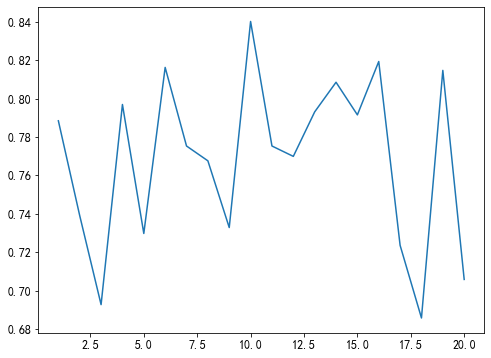

In [106]:
result_show(acc_list, 'acc')

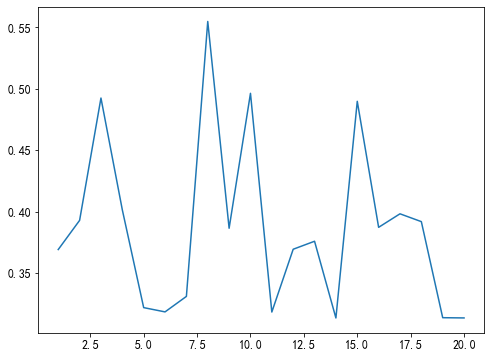

In [107]:
loss_list_ = [s.item() for s in loss_list]
result_show(loss_list_, 'loss')

### 模型加载与预测

In [109]:
def lstm_predict(test_loader=None):
    model = MyLSTM()
    model.load_state_dict(torch.load('data/lstm_model.pkl'), False)
    model.eval()
    torch.no_grad()
    for batch_id, (test_input, test_target) in enumerate(test_loader):
        outputs = model(test_input.unsqueeze(1))
        acc = (outputs.max(1).indices == test_target.max(1).indices).sum() / len(test_target.max(1).indices)
        print('acc：', acc)
        cls_report = classification_report(test_target.max(1).indices, outputs.max(1).indices)
        print(cls_report)

In [110]:
lstm_predict(test_add_loader)

acc： tensor(0.9219)
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        45
           1       0.79      1.00      0.88        19

    accuracy                           0.92        64
   macro avg       0.90      0.94      0.91        64
weighted avg       0.94      0.92      0.92        64

acc： tensor(0.9844)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.95      1.00      0.97        19

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64

acc： tensor(0.9688)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       0.97      0.97      0.97        33

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg  

### 模型预测

In [135]:

def lstm_predict_result(loader=None):
    model = MyLSTM()
    model.load_state_dict(torch.load('data/lstm_model.pkl'), False)
    model.eval()
    torch.no_grad()
    result_labels = []
    for batch_id, (input, target) in enumerate(loader):
        outputs = model(input.unsqueeze(1))
        result = outputs.max(1).indices
        result_labels.extend(result.numpy())
    return result_labels

In [136]:
result_labels = lstm_predict_result(test_pre_loader)

In [137]:
result_labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,


## 保存分类结果

In [138]:
df_wv = pd.read_csv('data/微信新闻分词并标注后的数据.csv')
df_wv.head()

,文章ID,公众号标题,发布时间,正文,文章分词,主题数量,类别
0,1001,2018，对自己好一点,2018-01-02 17:28,2017的旅程已经结束2018的未来拉开了帷幕新的一年里，请对自己好一点一辈子很长，漫漫人生...,"['2017', '旅程', '结束', '2018', '未来', '拉开', '帷幕',...",3,no label
1,1002,春节机票预订有窍门,2018-01-02 17:28,距离春节还有一个多月的时间，在线旅游网站的春节机票销售火爆，部分航线甚至一票难求。在这里分享...,"['距离', '春节', '一个多月', '时间', '在线旅游', '网站', '春节',...",3,no label
2,1003,冬日旅游知多D,2018-01-03 17:32,960万平方公里的祖国大地，四季都有独特美景冬天的旅行也别有一番风味但是冬季的严寒气候令很多...,"['960', '万平方公里', '祖国', '大地', '四季', '独特', '美景',...",5,no label
3,1004,2018冬季暖心之旅,2018-01-03 17:32,长按二维码，关注我们中心联系人：林小姐13709649096刘小姐13500078199罗小...,"['长', '二维码', '关注', '中心', '联系人', '林小姐', '137096...",0,0
4,1005,关于粤K27618号大客车排气管“喷火”事件的情况说明,2018-01-05 16:57,,[],0,0


In [151]:
pre_labels = []
i = 0
for label in df_wv['类别'].values.tolist():
    if label == 'no label':
        pre_labels.append(str(result_labels[i]))
        i += 1
    else:
        pre_labels.append(str(label))

In [152]:
len(pre_labels)

6286

In [153]:
df_wv['分类标签'] = pre_labels
df_wv['分类标签'] = list(df_wv['分类标签'].map({'1':'相关', '0':'不相关'}))

In [159]:
df_wv.to_csv('data/微信新闻预测后的数据.csv', index=False)

In [154]:
result1 = df_wv.loc[:, ['文章ID', '分类标签']]
result1.head()

,文章ID,分类标签
0,1001,相关
1,1002,相关
2,1003,相关
3,1004,不相关
4,1005,不相关


In [157]:
result1['分类标签'].value_counts()

不相关    3337
相关     2949
Name: 分类标签, dtype: int64

In [158]:
result1.to_csv('data/.result1.csv', index=False)